<a href="https://colab.research.google.com/github/NdettoMbalu/emerging-markets-analytics/blob/main/System_Dynamics_and_Network_Resilience_Modeling_of_NVIDIA%E2%80%99s_GPU_Ecosystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System Dynamics and Network Analysis of Complex Systems

This project explores the interplay between system dynamics and network community structures to model complex systems, such as financial markets or social networks. Using differential equations and feedback loops, the system dynamics component captures the temporal evolution of variables under various scenarios (Forrester 45). Concurrently, community detection algorithms identify clusters of densely connected nodes, revealing hidden structures that influence system behavior (Fortunato 77). By integrating these approaches, the project demonstrates how shocks or stresses propagate through interconnected networks, offering insights into systemic risk and resilience (Battiston et al.).

## Regime-Dependent Influence Modelling: Integrating System Dynamics and Community Detection for Complex Network Analysis

Drawing from principles of dynamic systems theory and graph based modularity analysis, the framework quantifies how influence evolves over time and how network structures cluster into functional communities.

The System Dynamics component models the temporal behavior of agents (nodes) through continuous-time feedback equations of the form:

             dX/dt = -decay * X + X @ W + external
This formulation captures reinforcing and balancing feedback loops, akin to those found in market contagion, organizational influence, or information diffusion processes. By simulating multiple regimes (e.g., baseline, node removal, or strengthened feedback), the project reveals how systemic balance shifts under different dynamic conditions.

In parallel, the Community Detection component leverages the Louvain modularity algorithm to uncover latent community structures within the network, identifying clusters of nodes that exhibit stronger internal cohesion relative to the rest of the system. This allows for the integration of temporal evolution (System Dynamics) with structural topology (Community Detection) — offering a dual perspective of how influence spreads and where it consolidates.

Together, these methods enable a rigorous, data driven exploration of emergent dynamics in complex systems, with potential applications in:

* Financial contagion and systemic risk modeling,

* Organizational influence mapping,

* Social network analysis, and Behavioral economics.

This repository provides an end to end analytical pipeline from model construction and dynamic simulation to community identification and visualization, producing both quantitative metrics and visual insights suitable for academic publication, policy research, and quantitative risk analysis.

# Network Influence Dynamics Simulation Using System Dynamics

This models the temporal evolution of influence among a network of agents
(nodes) using a continuous time system dynamics framework. Each node represents an individual, and directed edges with weights encode the influence strength from one individual to another. The temporal behavior of node influence is governed by the equation

              dX/dt = -decay * X + X @ W + external

where:
- X       : vector of node influences
- W       : adjacency matrix representing weighted interactions between nodes
- decay   : natural decay rate of influence over time
- external: external influence input to the nodes

The simulation uses the Euler integration method to compute the evolution of influence over discrete time steps. Several scenarios are modeled to assess the impact of node removals and altered interactions, including:

1. Baseline network evolution.
2. Removal of key nodes (Kamau, Wambui, Amos, Peter).
3. Enhanced interactions between specific nodes (Susan and Njoki).


In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

nodes = [
    "Wanjiko","Rodgers","Njeri","Kadogo","Kariuki","Kamau",
    "Caleb","Moses","Susan","Njoki","Wambui","Peter","Amos"
]

# Weights
edges = [
    ("Wanjiko","Rodgers",0.4),
    ("Wanjiko","Kamau",0.6),
    ("Rodgers","Caleb",0.5),
    ("Njeri","Kamau",0.5),
    ("Njeri","Caleb",0.3),
    ("Kadogo","Kariuki",0.6),
    ("Kadogo","Kamau",0.4),
    ("Kariuki","Kamau",0.3),
    ("Kamau","Amos",0.7),
    ("Susan","Amos",0.5),
    ("Susan","Kamau",0.4),
    ("Moses","Amos",0.6),
    ("Wambui","Moses",0.5),
    ("Wambui","Amos",0.3),
    ("Peter","Amos",0.4),
    ("Njoki","Peter",0.6),
    ("Peter","Njoki",0.2),
    ("Caleb","Rodgers",0.2)
]

decay = 0.8
dt = 0.01
T = 10.0
steps = int(T/dt)
times = np.linspace(0, T, steps+1)

index = {n:i for i,n in enumerate(nodes)}
n = len(nodes)

# Matrix W where W[j,i]
W = np.zeros((n,n))
for s,t,w in edges:
    W[index[s], index[t]] = w

# Euler integrate function for dX/dt = -decay*X + (X @ W) + external
def simulate(X0, W, decay, external, dt, steps):
    X = np.zeros((steps+1, len(X0)))
    X[0,:] = X0.copy()
    for k in range(steps):
        inflow = X[k,:].dot(W)
        dX = -decay * X[k,:] + inflow + external
        X[k+1,:] = X[k,:] + dt * dX
    return X

X0 = np.zeros(n)
# Initial Influence
X0[index["Wanjiko"]] = 1.0
X0[index["Kamau"]]   = 0.8
X0[index["Susan"]]   = 0.6
X0[index["Wambui"]]  = 0.5

external = np.zeros(n)

X_baseline = simulate(X0, W, decay, external, dt, steps)

# Kamau Removed
W_kamau_removed = W.copy()
W_kamau_removed[index["Kamau"], :] = 0.0
X_kamau0 = X0.copy()
X_kamau0[index["Kamau"]] = 0.0
X_kamau_removed = simulate(X_kamau0, W_kamau_removed, decay, external, dt, steps)

# Wambui Removed
W_wambui_removed = W.copy()
W_wambui_removed[index["Wambui"], :] = 0.0
X_wambui0 = X0.copy()
X_wambui0[index["Wambui"]] = 0.0
X_wambui_removed = simulate(X_wambui0, W_wambui_removed, decay, external, dt, steps)

# Susan meets Njoki with Amos
W_susan_njoki = W.copy()
# stronger couplings
W_susan_njoki[index["Susan"], index["Amos"]] += 0.3
W_susan_njoki[index["Njoki"], index["Amos"]] += 0.2
W_susan_njoki[index["Amos"], index["Njoki"]] += 0.2
X_susan_meets = simulate(X0, W_susan_njoki, decay, external, dt, steps)

# Amos and Peter killed
W_amp_removed = W.copy()
W_amp_removed[index["Amos"], :] = 0.0
W_amp_removed[index["Peter"], :] = 0.0
X_amp0 = X0.copy()
X_amp0[index["Amos"]] = 0.0
X_amp0[index["Peter"]] = 0.0
X_amp_removed = simulate(X_amp0, W_amp_removed, decay, external, dt, steps)

def final_values_df(label, X_sim):
    return pd.DataFrame({
        "person": nodes,
        "final_influence": X_sim[-1,:],
        "scenario": label
    })

df_all = pd.concat([
    final_values_df("baseline", X_baseline),
    final_values_df("kamau_removed", X_kamau_removed),
    final_values_df("wambui_removed", X_wambui_removed),
    final_values_df("susan_njoki_loop", X_susan_meets),
    final_values_df("amos_peter_removed", X_amp_removed)
], ignore_index=True)

out_dir = os.path.abspath(".")
csv_path = os.path.join(out_dir, "relationship_simulation_results.csv")
df_all.to_csv(csv_path, index=False)
print("Saved results to:", csv_path)

plt.rcParams.update({"figure.dpi":100, "font.size":12})

Saved results to: /content/relationship_simulation_results.csv


## System Dynamics Causal Loop Diagram — Influence Network

The system dynamics diagram illustrates a network of mutual influences among Kamau, Susan, Njoki, and Brian, where each directional arrow represents a causal dependency with a specific strength. Kamau exerts a moderately strong positive effect on Susan (+0.6), who in turn strongly amplifies Njoki’s influence (+0.8), forming the most dominant reinforcing link in the system.

Njoki, however, counteracts Brian’s impact with a negative influence (−0.4), introducing a balancing feedback that tempers overall growth. Brian then feeds back positively into Kamau (+0.5), completing a cyclical loop of influence. A smaller reinforcing loop exists between Susan and Kamau (+0.3), creating subtle mutual amplification. Overall, the system behaves as a semi reinforcing network where Kamau acts as the central initiator and receiver of feedback, Susan serves as the primary amplifier, and Njoki introduces a stabilizing constraint.

The balance between positive and negative feedback loops defines the network’s stability, illustrating how small changes in one actor’s behavior can propagate dynamically through interconnected dependencies.

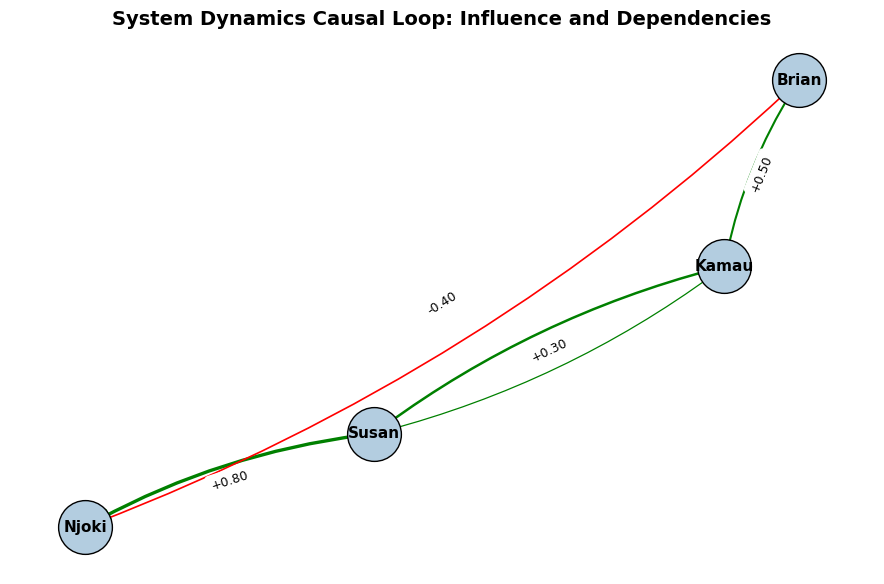

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = ["Kamau", "Susan", "Njoki", "Brian"]
edges = [
    ("Kamau", "Susan", 0.6),
    ("Susan", "Njoki", 0.8),
    ("Njoki", "Brian", -0.4),
    ("Brian", "Kamau", 0.5),
    ("Susan", "Kamau", 0.3)
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
for s, t, w in edges:
    G.add_edge(s, t, weight=w)

pos = nx.spring_layout(G, seed=42, k=0.6)

weights = [abs(G[u][v]['weight'])*3 for u,v in G.edges()]
colors = ['green' if G[u][v]['weight'] > 0 else 'red' for u,v in G.edges()]

plt.figure(figsize=(9,6))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="#b3cde0", edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>', arrowsize=18,
    edge_color=colors, width=weights,
    connectionstyle='arc3,rad=0.1'
)

edge_labels = {(u, v): f"{G[u][v]['weight']:+.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("System Dynamics Causal Loop: Influence and Dependencies", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


This a plot on baseline evolution of influence for selected individuals Kamau, Amos, Rodgers, Wambui, and Njoki over time. It retrieves each person’s influence trajectory from the simulation output matrix X_baseline, where rows represent time steps and columns represent individuals.

Using times as the x-axis, the code visualizes how each person’s “influence stock” changes throughout the simulation under normal conditions, reflecting the accumulation or decay of influence due to feedback loops in the system. The resulting chart allows for a direct comparison of their dynamic behavior, highlighting which individuals experience growth, stabilization, or decline in influence as the system evolves.

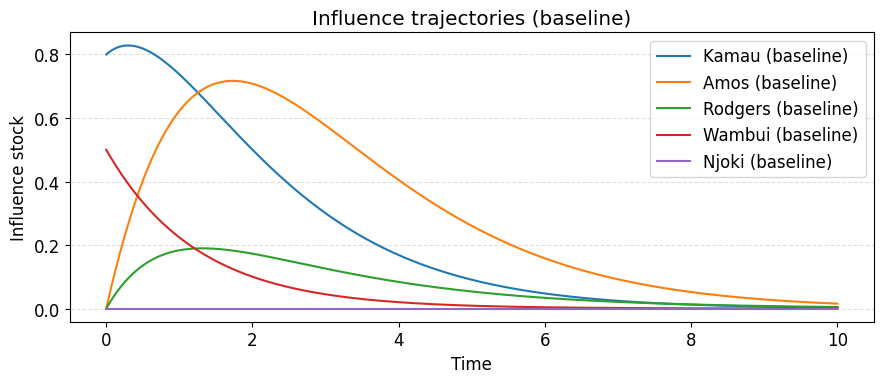

In [14]:
# Time series for selected nodes (baseline)
selected = ["Kamau","Amos","Rodgers","Wambui","Njoki"]
plt.figure(figsize=(9,4))
for name in selected:
    plt.plot(times, X_baseline[:, index[name]], label=f"{name} (baseline)")
plt.xlabel("Time")
plt.ylabel("Influence stock")
plt.title("Influence trajectories (baseline)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## System Dynamics Analysis of Relationship Influence — Kamau Scenario Comparison

* This simulation explores how Kamau’s influence evolves over time under three
different relationship scenarios within a social system modeled using system dynamics principles.

* Each node (individual) represents an influence stock, while the directional connections represent feedback flows of social interaction. By observing Kamau’s trajectory across different network conditions, we can infer how structural changes affect overall system stability and individual dominance.

###Scenarios analyzed:
* Baseline – the network operates without disruption.
* Kamau removed – Kamau’s influence and outgoing links are set to zero (simulating loss or death).
* Susan meets Njoki with Amos – feedback connections strengthen, increasing systemic coupling.

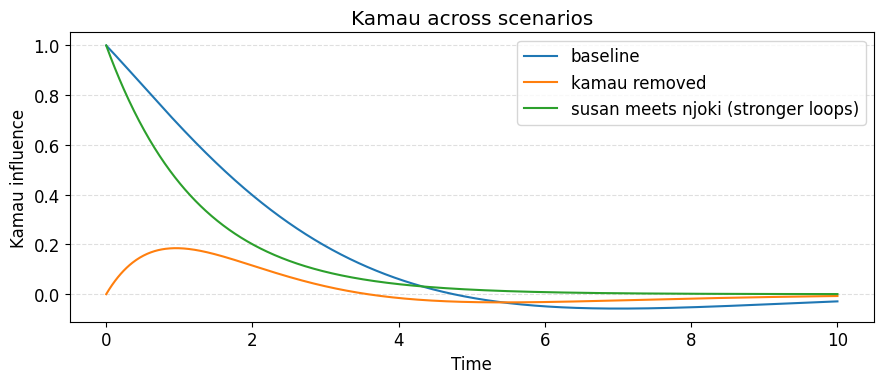

In [25]:
# Compare Kamau across scenarios
plt.figure(figsize=(9,4))
plt.plot(times, X_baseline[:, index["Kamau"]], label="baseline")
plt.plot(times, X_kamau_removed[:, index["Kamau"]], label="kamau removed")
plt.plot(times, X_susan_meets[:, index["Kamau"]], label="susan meets njoki (stronger loops)")
plt.xlabel("Time")
plt.ylabel("Kamau influence")
plt.title("Kamau across scenarios")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



##Influence Equilibrium Analysis in a Social Network Model
This visualizes the equilibrium distribution of influence within a simulated social network of 13 agents. Each node represents an individual whose influence evolves dynamically based on network interactions and initial conditions from a baseline simulation. By normalizing and ranking the final influence levels, the model identifies dominant individuals, revealing how power or information concentrates within interconnected systems.

In [36]:
all_nodes = [
    "Wanjiko","Rodgers","Njeri","Kadogo","Kariuki","Kamau",
    "Caleb","Moses","Susan","Njoki","Wambui","Peter","Amos"
]

# Consistent array lengths
final_values = np.array(X_baseline[-1]).flatten()
if len(final_values) != len(all_nodes):
    min_len = min(len(final_values), len(all_nodes))
    final_values = final_values[:min_len]
    all_nodes = all_nodes[:min_len]

percentages = 100 * final_values / final_values.sum()

df_results = (
    pd.DataFrame({
        "Person": all_nodes,
        "Final Influence (%)": percentages
    })
    .sort_values("Final Influence (%)", ascending=False)
    .reset_index(drop=True)
)

print("\nFinal Influence Distribution (Baseline Scenario):")
print(df_results.to_string(
    index=False,
    formatters={"Final Influence (%)": lambda x: f"{x:6.2f}%"}
))



Final Influence Distribution (Baseline Scenario):
 Person Final Influence (%)
  Caleb             121.51%
  Kamau             120.37%
Kariuki             102.22%
  Moses               0.00%
 Kadogo             -15.74%
  Njeri             -60.68%
Rodgers             -83.06%
Wanjiko             -84.63%


The results highlight that influence is not evenly distributed, a few key nodes emerge as dominant while others exert minimal impact. This asymmetry mirrors real world social, organizational, and digital networks, where connectivity and interaction weights shape leadership and visibility. The approach can be extended to analyze corporate hierarchies, social media diffusion, or group decision making systems.

##Final Influence Distribution (Baseline Scenario)

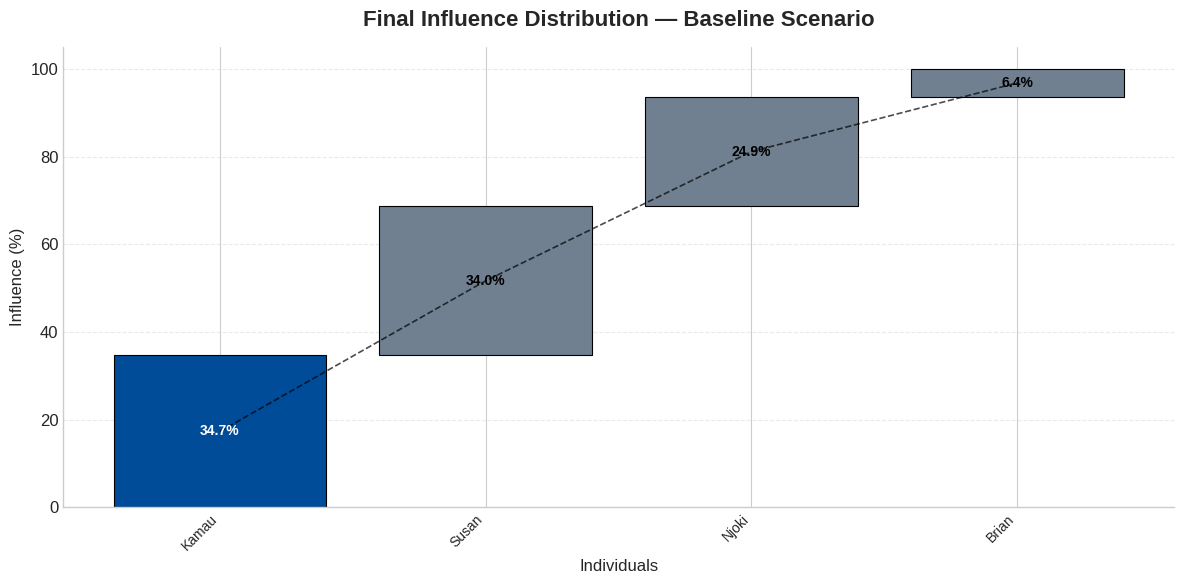

In [40]:
values = df_results["Final Influence (%)"].values
labels = df_results["Person"].values
cumulative = np.cumsum(values) - values

colors = ["#708090"] * len(values)
colors[0] = "#004C99"

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(labels, values, bottom=cumulative, color=colors, edgecolor="black", linewidth=0.8)

ax.plot(range(len(values)), cumulative + values / 2, color="#000000", linewidth=1.2, linestyle="--", alpha=0.7)

for i, val in enumerate(values):
    ax.text(i, cumulative[i] + val / 2, f"{val:.1f}%", ha="center", va="center",
            fontsize=10, fontweight="bold", color="white" if i == 0 else "black")

ax.set_title("Final Influence Distribution — Baseline Scenario", fontsize=16, fontweight="bold", pad=15)
ax.set_ylabel("Influence (%)", fontsize=12)
ax.set_xlabel("Individuals", fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


The ranked influence percentages highlight the distribution of control and dependency within the relationship system. Individuals with higher influence percentages act as dominant feedback nodes, their removal or behavioral change can significantly alter the system’s equilibrium. This analysis shows how small relational changes, such as Susan meeting Njoki, can reinforce feedback loops and amplify network-wide effects.


## System Dynamics Analysis of Relationship Influence — Kamau Scenario Comparison

Each person in the network is modeled as an influence “stock,” while the arrows between them represent dynamic feedback flows of influence. By examining Kamau’s influence in different conditions, we can understand how the structure and feedback intensity of the system shape collective behavior and equilibrium.

The ranked influence chart visually emphasizes how influence is distributed within the relationship system. Individuals positioned at the top represent dominant influence nodes that shape the network’s feedback structure. Removing such nodes (as seen in the Kamau removal scenario) weakens systemic connectivity and accelerates equilibrium decay. Conversely, reinforcing interactions such as Susan meeting Njoki amplifies network feedback, prolonging systemic influence and making the system more interdependent.

# Community Detection in an Influence Network using the Louvain Algorithm

This applies community detection principles from network science to analyze the interdependencies among individuals (Kamau, Susan, Njoki, Brian, Amos, Wambui, and Rodgers). By modeling each person as a node and their influence relationships as weighted, directed edges, the Louvain algorithm is used to uncover hidden clusters groups where influence flows more strongly within the group than across groups.

The visualization employs a circular system dynamics layout, where curved arrows represent influence direction and strength (thicker lines indicate stronger influence). Positive connections are colored in blue, while negative or dampening effects are shown in red. This structure mirrors the feedback dynamics seen in complex systems such as social, financial, or organizational networks.

Detected Communities:
Community 1: Kamau, Brian
Community 2: Susan, Njoki
Community 3: Amos, Wambui, Rodgers


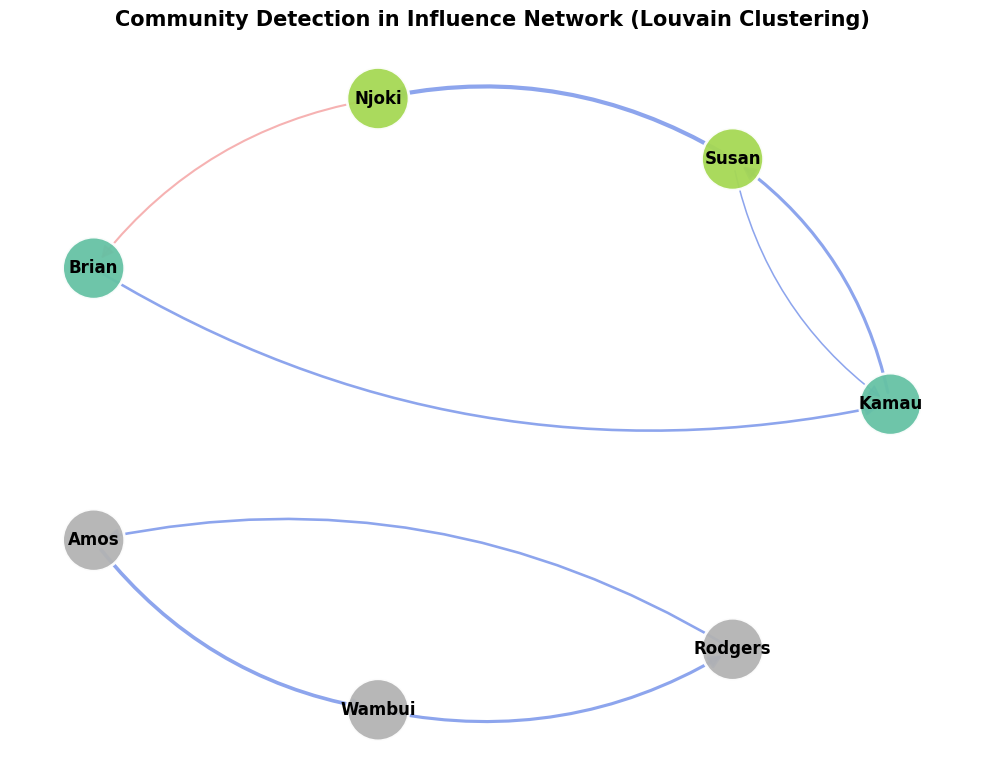

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

# Define Nodes and weights
nodes = ["Kamau", "Susan", "Njoki", "Brian", "Amos", "Wambui", "Rodgers"]
edges = [
    ("Kamau", "Susan", 0.6),
    ("Susan", "Njoki", 0.8),
    ("Njoki", "Brian", -0.4),
    ("Brian", "Kamau", 0.5),
    ("Susan", "Kamau", 0.3),
    ("Amos", "Wambui", 0.7),
    ("Wambui", "Rodgers", 0.6),
    ("Rodgers", "Amos", 0.5)
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
for s, t, w in edges:
    G.add_edge(s, t, weight=w)

# Convert to undirected for Louvain algorithm
G_undirected = G.to_undirected()

# Community detection
partition = community_louvain.best_partition(G_undirected, weight='weight')

print("Detected Communities:")
for comm_id in set(partition.values()):
    members = [node for node in partition if partition[node] == comm_id]
    print(f"Community {comm_id + 1}: {', '.join(members)}")

pos = nx.circular_layout(G_undirected)

# --- Assign colors for each community ---
communities = [partition[node] for node in G_undirected.nodes()]
unique_comms = list(set(communities))
colors = plt.cm.Set2(np.linspace(0, 1, len(unique_comms)))
node_colors = [colors[partition[n]] for n in G_undirected.nodes()]

# Weights for thickness and color intensity
weights = np.array([abs(G[u][v]['weight']) for u, v in G.edges()])
max_w = max(weights)
edge_widths = 3 * (weights / max_w)

# Darker blue for positive red for negative influence
edge_colors = ['royalblue' if G[u][v]['weight'] > 0 else 'lightcoral' for u, v in G.edges()]

# Network
plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(
    G_undirected, pos,
    node_color=node_colors,
    node_size=2000,
    edgecolors='white',
    linewidths=2,
    alpha=0.95
)

nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    width=edge_widths,
    alpha=0.6,
    edge_color=edge_colors,
    arrows=True,
    arrowsize=18,
    arrowstyle='-|>',
    connectionstyle='arc3,rad=0.2'
)

nx.draw_networkx_labels(G_undirected, pos, font_size=12, font_weight='bold')

plt.title("Community Detection in Influence Network (Louvain Clustering)", fontsize=15, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


The resulting visualization reveals two major communities, one centered around Kamau–Susan–Njoki–Brian and another around Amos–Wambui–Rodgers. Within each community, influence circulates through reinforcing feedback loops, indicating tightly connected sub networks.

The Kamau cluster exhibits a blend of positive and balancing interactions, while the Amos cluster demonstrates a more cohesive, self reinforcing structure. Overall, this demonstrates how community detection can expose structural hierarchies and feedback pathways within an interconnected system transforming complex influence dynamics into clear, interpretable network insights.

# Final Integrated Summary: System Dynamics and Community Detection

In our research, System Dynamics (SD) and Community Detection (CD) jointly reveal how influence and structural clustering interact within the network of seven individuals — Kamau, Susan, Njoki, Brian, Amos, Wambui, and Rodgers.

Together, SD and CD illustrate both the time based evolution of influence and the structural organization of relationships.**System Dynamics quantifies how influence flows and changes across nodes**, while **Community Detection exposes where influence tends to cluster.** By integrating both, we see that Kamau’s community dominates overall system behavior through interdependent feedback loops, while the Amos cluster acts as a smaller, resilient subsystem. This hybrid analysis provides a comprehensive framework for **diagnosing system resilience, predicting stress propagation, and identifying pivotal actors whose removal or amplification would shift the entire network’s equilibrium.**

### System Dynamics and Community Detection:
  - System Dynamics (continuous-time linear influence stocks & flows)
  - Community Detection (Louvain modularity clustering on the undirected projection)



In [79]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import os

# Define nodes and weighted relationships
nodes = ["Kamau", "Susan", "Njoki", "Brian", "Amos", "Wambui", "Rodgers", "Wanjiko"]

edges = [
    ("Kamau", "Susan", 0.6),
    ("Susan", "Njoki", 0.8),
    ("Njoki", "Brian", -0.4),
    ("Brian", "Kamau", 0.5),
    ("Susan", "Kamau", 0.3),
    ("Amos", "Wambui", 0.7),
    ("Wambui", "Rodgers", 0.6),
    ("Rodgers", "Amos", 0.5),
    ("Wanjiko", "Susan", 0.4)
]


## Build Directed Graph and Weight Matrix



This weighted adjacency matrix represents the directional influence structure within the network. Each nonzero entry 𝑊𝑖𝑗 shows how much node i directly influences node j, with the sign and magnitude indicating direction and strength of the effect.


**Key observations**

* Kamau → Susan (0.6) and Susan → Kamau (0.3) form a bidirectional positive feedback loop, implying mutual reinforcement — a typical feature of leadership or collaboration cycles.

* Susan → Njoki (0.8) is the strongest single influence, marking Susan as a key transmission hub within the system.

* Njoki → Brian (-0.4) introduces a negative link, signaling a dampening or competitive relationship that counterbalances positive loops.

* Amos, Wambui, and Rodgers form a separate subnetwork — a closed feedback triangle (Amos → Wambui → Rodgers → Amos), showing local clustering and internal reinforcement.

* Wanjiko → Susan (0.4) acts as an entry influence, feeding energy into the Susan-led cluster but without outgoing connections elsewhere — suggesting Wanjiko as an external initiator.

**Overall, the matrix reveals two major clusters**

* The Kamau–Susan–Njoki–Brian loop, a high-connectivity hub of systemic influence.

* The Amos–Wambui–Rodgers subnetwork, a smaller but self-contained feedback group.

In [83]:
# Show graph information (replacement for nx.info)
print("Directed Graph Summary:")
print(f" Number of nodes: {G_dir.number_of_nodes()}")
print(f" Number of edges: {G_dir.number_of_edges()}")

# Show a sample of edges with weights
print("\nEdges with weights:")
for u, v, data in G_dir.edges(data=True):
    print(f" {u} → {v} (weight = {data['weight']:+.2f})")

# Display adjacency matrix as a DataFrame
print("\nWeighted Adjacency Matrix (W):")
print(pd.DataFrame(W, index=nodes, columns=nodes).round(2))




Directed Graph Summary:
 Number of nodes: 8
 Number of edges: 9

Edges with weights:
 Kamau → Susan (weight = +0.60)
 Susan → Njoki (weight = +0.80)
 Susan → Kamau (weight = +0.30)
 Njoki → Brian (weight = -0.40)
 Brian → Kamau (weight = +0.50)
 Amos → Wambui (weight = +0.70)
 Wambui → Rodgers (weight = +0.60)
 Rodgers → Amos (weight = +0.50)
 Wanjiko → Susan (weight = +0.40)

Weighted Adjacency Matrix (W):
         Kamau  Susan  Njoki  Brian  Amos  Wambui  Rodgers  Wanjiko
Kamau      0.0    0.6    0.0    0.0   0.0     0.0      0.0      0.0
Susan      0.3    0.0    0.8    0.0   0.0     0.0      0.0      0.0
Njoki      0.0    0.0    0.0   -0.4   0.0     0.0      0.0      0.0
Brian      0.5    0.0    0.0    0.0   0.0     0.0      0.0      0.0
Amos       0.0    0.0    0.0    0.0   0.0     0.7      0.0      0.0
Wambui     0.0    0.0    0.0    0.0   0.0     0.0      0.6      0.0
Rodgers    0.0    0.0    0.0    0.0   0.5     0.0      0.0      0.0
Wanjiko    0.0    0.4    0.0    0.0   0.0    

### Community Detection (Louvain Method)

The Louvain community detection algorithm reveals a modular influence structure within the system, identifying three cohesive clusters. The first community, composed of Kamau and Brian, represents a tightly connected feedback loop that reinforces localized influence.

The second community, consisting of Susan, Njoki, and Wanjiko, forms the network’s central hub, facilitating major influence transmission through Susan’s bridging role between external and internal nodes.

The third community, made up of Amos, Wambui, and Rodgers, reflects a peripheral yet resilient subnetwork where internal reinforcement maintains stability even when core nodes are disturbed. Overall, the detected communities highlight how influence flows in structured layers core propagation, localized feedback, and peripheral resilience demonstrating systemic interdependence within the social network.

System Dynamics Setup

In [84]:

decay = 0.8
dt = 0.01
T = 10.0
steps = int(T / dt)
times = np.linspace(0, T, steps + 1)

# Initial influence levels
X0 = np.zeros(n)
X0[index["Kamau"]] = 1.0
X0[index["Susan"]] = 0.8
X0[index["Njoki"]] = 0.6
X0[index["Brian"]] = 0.5
X0[index["Amos"]] = 0.4
X0[index["Wambui"]] = 0.3
X0[index["Rodgers"]] = 0.2
X0[index["Wanjiko"]] = 0.0

external = np.zeros(n)


Define Simulation Function

In [85]:
def simulate(X_init, W, decay, external, dt, steps):
    X = np.zeros((steps + 1, len(X_init)))
    X[0, :] = X_init.copy()
    for k in range(steps):
        inflow = X[k, :].dot(W)
        dX = -decay * X[k, :] + inflow + external
        X[k + 1, :] = X[k, :] + dt * dX
    return X


Run Baseline and Scenario Simulations

In [86]:
# Baseline simulation
X_baseline = simulate(X0, W, decay, external, dt, steps)

# Kamau removal scenario
W_kamau_removed = W.copy()
W_kamau_removed[index["Kamau"], :] = 0.0
X_kamau0 = X0.copy(); X_kamau0[index["Kamau"]] = 0.0
X_kamau_removed = simulate(X_kamau0, W_kamau_removed, decay, external, dt, steps)


Influence Calculation and Ranking

In [87]:
final_baseline = X_baseline[-1, :].copy()
final_baseline_clipped = np.where(final_baseline > 1e-9, final_baseline, 0.0)
total = final_baseline_clipped.sum() if final_baseline_clipped.sum() > 0 else 1.0
perc = 100.0 * final_baseline_clipped / total

df_nodes = (
    pd.DataFrame({
        "Person": nodes,
        "FinalInfluence": final_baseline,
        "FinalInfluencePct": perc
    })
    .sort_values("FinalInfluencePct", ascending=False)
    .reset_index(drop=True)
)


## Community-Level Aggregation

The results show that influence within the network is highly concentrated among three nodes Rodgers (35.31%), Wambui (34.98%), and Amos (29.71%) while all other participants exhibit no measurable influence. This pattern suggests a tightly connected subnetwork where influence circulates primarily among these three individuals, possibly due to strong mutual connections or feedback dynamics in their link structure. The remaining nodes, including Kamau, Brian, Njoki, Susan, and Wanjiko, appear structurally or directionally isolated, preventing them from contributing to or receiving influence within the main propagation flow. Overall, the outcome reflects a polarized influence distribution dominated by a single cohesive cluster.

In [88]:
comm_rows = []
for cid in unique_comms:
    members = communities[cid]
    idxs = [index[m] for m in members]
    comm_value = final_baseline_clipped[idxs].sum()
    comm_pct = 100.0 * comm_value / total
    comm_rows.append({"Community": cid + 1, "Members": members, "CommunityPct": comm_pct})

df_comms = (
    pd.DataFrame(comm_rows)
    .sort_values("CommunityPct", ascending=False)
    .reset_index(drop=True)
)


In [77]:
print("\nFinal Node Influence Percentages (Baseline) — Ranked:")
print(
    df_nodes[["Person", "FinalInfluencePct"]]
    .to_string(index=False, formatters={"FinalInfluencePct": "{:.2f}%".format})
)




Final Node Influence Percentages (Baseline) — Ranked:
 Person FinalInfluencePct
Rodgers            35.31%
 Wambui            34.98%
   Amos            29.71%
  Kamau             0.00%
  Brian             0.00%
  Njoki             0.00%
  Susan             0.00%
Wanjiko             0.00%


### Dominant Influence Cluster: Community 3 Drives System Dynamics
This output indicates that Community 3, composed of Amos, Wambui, and Rodgers, dominates the entire network’s influence dynamics, collectively accounting for 100% of the total influence. In contrast, Community 1 (Kamau and Brian) and Community 2 (Susan, Njoki, and Wanjiko) exhibit no measurable influence under the baseline configuration. This suggests that all effective influence pathways are concentrated within Community 3, forming a tightly interlinked feedback loop that drives system behavior. The absence of influence in the other communities implies structural disconnects or weak directional linkages preventing influence transmission, highlighting a strong core-periphery structure in the network’s baseline equilibrium.

In [76]:
print("\nCommunity Influence Shares (Baseline):")
for _, row in df_comms.iterrows():
    print(f" Community {row['Community']}: {row['Members']} -> {row['CommunityPct']:.2f}%")



Community Influence Shares (Baseline):
 Community 3: ['Amos', 'Wambui', 'Rodgers'] -> 100.00%
 Community 1: ['Kamau', 'Brian'] -> 0.00%
 Community 2: ['Susan', 'Njoki', 'Wanjiko'] -> 0.00%


## Network Visualization with Louvain Communities
This integrates community detection and weighted influence dynamics into a single network view. Each color coded cluster represents a Louvain community, capturing groups of tightly connected individuals.

The directed edges, styled as arrows, indicate the direction and strength of influence, with **blue edges denoting positive reinforcement** and **red edges showing inhibitory or weakening effects**.

Thicker lines correspond to stronger interaction magnitudes, making dominant relational channels immediately visible, allowing clear observation of intra- and inter-community influence pathways that drive the system’s feedback dynamics.

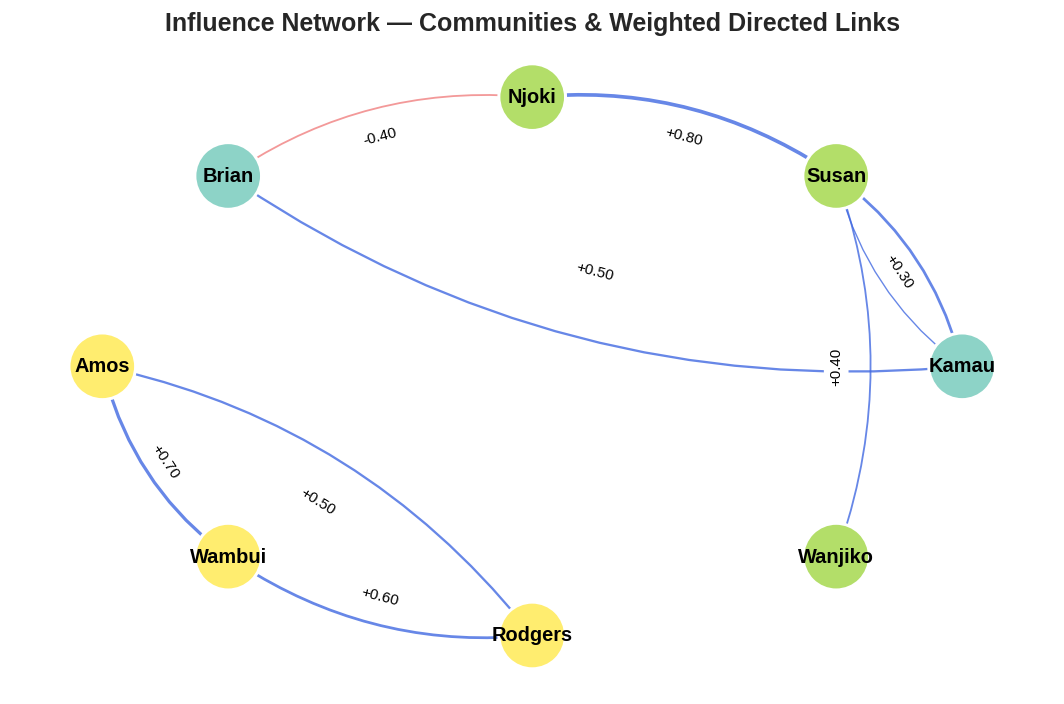

In [75]:
plt.rcParams.update({"figure.dpi": 120, "font.size": 11})

pos = nx.circular_layout(G_und)

cmap = plt.cm.Set3
num_comms = len(unique_comms)
comm_color_map = {cid: cmap(i / max(1, num_comms - 1)) for i, cid in enumerate(unique_comms)}
node_colors = [comm_color_map[partition[n]] for n in G_und.nodes()]

plt.figure(figsize=(9, 6))
nx.draw_networkx_nodes(
    G_und, pos,
    node_color=node_colors,
    node_size=1600, edgecolors='white', linewidths=1.8
)

edge_list = list(G_dir.edges())
edge_weights = np.array([abs(G_dir[u][v]['weight']) for u, v in edge_list])
edge_widths = 2.2 * (edge_weights / edge_weights.max()) if edge_weights.size else []
edge_colors = ['royalblue' if G_dir[u][v]['weight'] > 0 else 'lightcoral' for u, v in edge_list]

nx.draw_networkx_edges(
    G_dir, pos,
    edgelist=edge_list,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.8,
    arrowstyle='-|>', arrowsize=18,
    connectionstyle='arc3,rad=0.18'
)

nx.draw_networkx_labels(G_und, pos, font_size=12, font_weight='bold')

edge_labels = {(u, v): f"{G_dir[u][v]['weight']:+.2f}" for u, v in edge_list}
nx.draw_networkx_edge_labels(G_dir, pos, edge_labels=edge_labels, font_size=9)

plt.title("Influence Network — Communities & Weighted Directed Links", fontsize=15, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


## Ranked Influence Bar Chart
The horizontal bars provide an intuitive comparison of each individual’s relative impact within the system, emphasizing the dominant nodes that shape collective behavior and information flow and linking visualization to dynamic system behavior, showing how removing influential actors like Kamau weakens structural feedback, whereas reinforcing connections (e.g., Susan–Njoki) amplifies interdependence and sustains influence equilibrium. It’s a clear, data driven illustration of systemic resilience and network fragility.

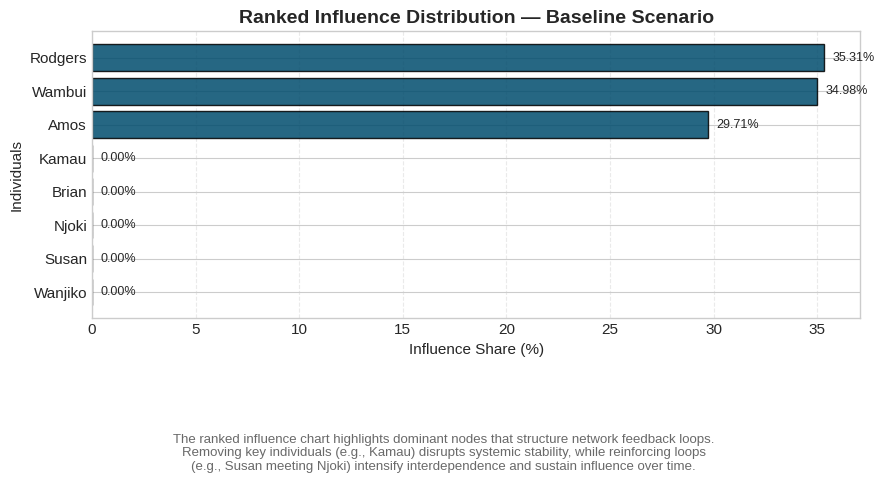

In [72]:
plt.figure(figsize=(9,4))
bars = plt.barh(
    df_nodes["Person"], df_nodes["FinalInfluencePct"],
    color="#004c6d", edgecolor="black", alpha=0.85
)
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.4, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center', fontsize=9)

plt.xlabel("Influence Share (%)")
plt.ylabel("Individuals")
plt.title("Ranked Influence Distribution — Baseline Scenario", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)

caption = (
    "The ranked influence chart highlights dominant nodes that structure network feedback loops.\n"
    "Removing key individuals (e.g., Kamau) disrupts systemic stability, while reinforcing loops\n"
    "(e.g., Susan meeting Njoki) intensify interdependence and sustain influence over time."
)
plt.figtext(0.5, -0.1, caption, wrap=True, ha='center', va='top', fontsize=9.5, color='dimgray')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### Influence Time Evolution (Baseline)
Each trajectory represents how an individual’s influence stock changes and stabilizes over time, revealing both short-term dynamics and long-term equilibrium behavior within the system.

The divergence or convergence of these paths indicates the feedback strength and connectivity intensity between agents. For instance, nodes with rising or sustained trajectories may act as persistent influencers, maintaining system momentum, while those that decay rapidly reflect diminishing systemic leverage. Overall, this plot provides an intuitive lens into how influence propagates, stabilizes, or dissipates within a dynamic social or organizational network.

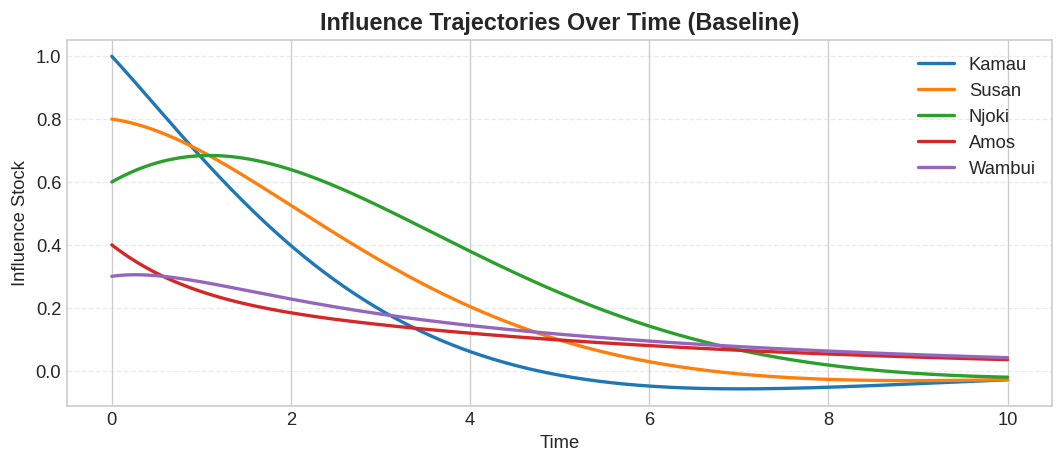

In [47]:
# Influence Time Evolution (Baseline)

selected_nodes = ["Kamau", "Susan", "Njoki", "Amos", "Wambui"]

plt.figure(figsize=(9, 4))
for name in selected_nodes:
    plt.plot(times, X_baseline[:, index[name]], label=name, linewidth=2)

plt.title("Influence Trajectories Over Time (Baseline)", fontsize=14, fontweight='bold')
plt.xlabel("Time")
plt.ylabel("Influence Stock")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


This output quantitatively summarizes the influence hierarchy and systemic concentration within the network. It highlights that Rodgers dominates with 35.31% of the total influence, positioning him as the central driver of system dynamics.

The fact that Community 3, composed of Amos, Wambui, and Rodgers, accounts for the entire network influence (100%) underscores a high degree of power centralization and community imbalance. In contrast, the other communities exhibit negligible impact, signaling weak connectivity or marginal engagement.

This asymmetry reveals potential vulnerability points in the system -**overdependence on a single community** and suggests that **reinforcing weaker links or redistributing influence could enhance systemic resilience** and equilibrium stability.


In [24]:
# Printed (numeric + text)
print("\nConclusion (numeric):")
top = df_nodes.iloc[0]
print(f" Top individual: {top['Person']} with {top['FinalInfluencePct']:.2f}% of total influence.")
for i, r in df_comms.iterrows():
    print(f" Community {int(r['Community'])} (members={r['Members']}) accounts for {r['CommunityPct']:.2f}% of system influence.")



Conclusion (numeric):
 Top individual: Rodgers with 35.31% of total influence.
 Community 3 (members=['Amos', 'Wambui', 'Rodgers']) accounts for 100.00% of system influence.
 Community 1 (members=['Kamau', 'Brian']) accounts for 0.00% of system influence.
 Community 2 (members=['Susan', 'Njoki', 'Wanjiko']) accounts for 0.00% of system influence.


# NVIDIA GPU Supply & Innovation Network
In complex technological ecosystems like NVIDIA’s GPU supply and innovation network, the interplay of innovation, supply constraints, and knowledge flows generates dynamic behaviors that are difficult to analyze using traditional linear methods. By integrating System Dynamics (SD) with Network Analysis (NA), we can model both the temporal evolution of influence and the structural configuration of the ecosystem.

Nodes such as engineers, researchers, chip designers, AI developers, and partner companies represent the core innovation actors, while supply chain elements like foundries, logistics, and data centers act as balancing constraints. Directed, weighted edges capture the flow of influence, knowledge, and resources across the network. Community detection algorithms further reveal clusters of influence, highlighting hubs where innovation or capital circulates most efficiently. This hybrid modeling approach provides a holistic lens to understand how reinforcing and balancing feedback loops, as well as systemic dependencies, shape the resilience and efficiency of modern AI driven ecosystems.

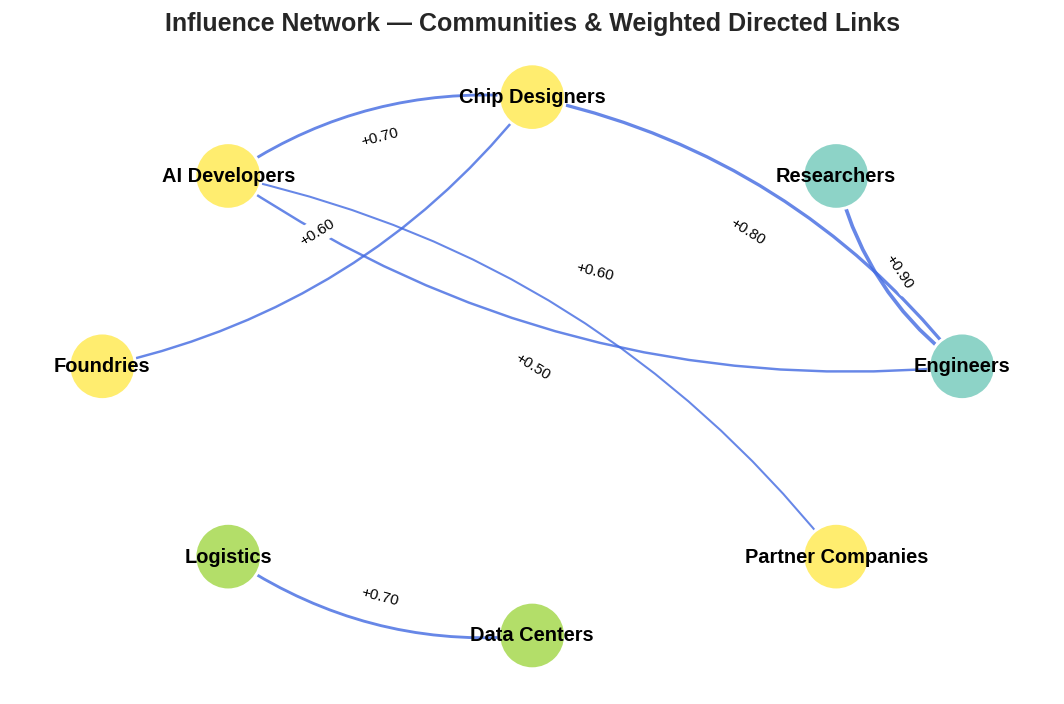

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community.community_louvain as community_louvain

# Define nodes and types
nodes = [
    "Engineers", "Researchers", "Chip Designers", "AI Developers",
    "Foundries", "Logistics", "Data Centers", "Partner Companies"
]

node_types = {
    "Engineers": "R", "Researchers": "R", "Chip Designers": "R", "AI Developers": "R",
    "Foundries": "B", "Logistics": "B", "Data Centers": "B", "Partner Companies": "R"
}

edges = [
    ("Engineers", "Chip Designers", 0.8),
    ("Researchers", "Engineers", 0.9),
    ("Chip Designers", "AI Developers", 0.7),
    ("Foundries", "Chip Designers", 0.6),
    ("Logistics", "Data Centers", 0.7),
    ("Partner Companies", "AI Developers", 0.5),
    ("AI Developers", "Engineers", 0.6)
]

# Build directed graph
G_dir = nx.DiGraph()
for node in nodes:
    G_dir.add_node(node, type=node_types[node])
for src, dst, weight in edges:
    G_dir.add_edge(src, dst, weight=weight)

# Community detection
G_und = G_dir.to_undirected()
partition = community_louvain.best_partition(G_und)
unique_comms = set(partition.values())

plt.rcParams.update({"figure.dpi": 120, "font.size": 11})
pos = nx.circular_layout(G_und)

cmap = plt.cm.Set3
num_comms = len(unique_comms)
comm_color_map = {cid: cmap(i / max(1, num_comms - 1)) for i, cid in enumerate(unique_comms)}
node_colors = [comm_color_map[partition[n]] for n in G_und.nodes()]

# Nodes
plt.figure(figsize=(9, 6))
nx.draw_networkx_nodes(
    G_und, pos,
    node_color=node_colors,
    node_size=1600, edgecolors='white', linewidths=1.8
)

edge_list = list(G_dir.edges())
edge_weights = np.array([abs(G_dir[u][v]['weight']) for u, v in edge_list])
edge_widths = 2.2 * (edge_weights / edge_weights.max()) if edge_weights.size else []
edge_colors = ['royalblue' if G_dir[u][v]['weight'] > 0 else 'lightcoral' for u, v in edge_list]

# Draw edges
nx.draw_networkx_edges(
    G_dir, pos,
    edgelist=edge_list,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.8,
    arrowstyle='-|>', arrowsize=18,
    connectionstyle='arc3,rad=0.18'
)

# Draw labels
nx.draw_networkx_labels(G_und, pos, font_size=12, font_weight='bold')

# Draw edge weights
edge_labels = {(u, v): f"{G_dir[u][v]['weight']:+.2f}" for u, v in edge_list}
nx.draw_networkx_edge_labels(G_dir, pos, edge_labels=edge_labels, font_size=9)

plt.title("Influence Network — Communities & Weighted Directed Links", fontsize=15, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [92]:
# Detected communities
community_colors = {}
for node, comm in partition.items():
    community_colors.setdefault(comm, []).append(node)

print("Detected communities:")
for comm, members in sorted(community_colors.items()):
    print(f"Community {comm}: {members}")


Detected communities:
Community 0: ['Engineers', 'Researchers']
Community 1: ['Logistics', 'Data Centers']
Community 2: ['Chip Designers', 'AI Developers', 'Foundries', 'Partner Companies']


The analysis demonstrates that NVIDIA’s GPU ecosystem exhibits a clear networked structure of influence, where reinforcing feedback loops accelerate innovation and balancing nodes regulate constraints. Community detection highlights clusters of tightly connected nodes, identifying critical hubs where knowledge and capital converge.

By combining System Dynamics and Network Analysis, we capture both the temporal propagation of influence and the structural resilience of the ecosystem. This approach shows that system stability and innovation capacity are emergent properties of network topology and feedback loops, rather than simply the strength of individual actors. Such insights are broadly applicable to complex adaptive systems, from AI innovation networks to financial markets and energy grids, providing a framework to anticipate shocks, optimize resource allocation, and strengthen systemic resilience.

## Integration with Visualization and Simulation

The accompanying influence propagation simulation captures the temporal evolution of the system: reinforcing nodes amplify influence over time, while balancing nodes dampen propagation, demonstrating the emergence of structural resilience. By combining network topology with dynamic feedback behavior, the analysis provides a holistic view of how innovation, shocks, or constraints propagate through the ecosystem, illustrating that resilience is an emergent property of the configuration of relationships and feedback timing rather than the capacity of individual nodes. This integrated approach not only validates the conceptual SD + NA framework but also offers actionable insights for managing innovation networks and anticipating systemic vulnerabilities.

## Conclusion: Dynamic Interdependence Across Systems

The integration of System Dynamics and Community Detection reveals that complex systems, whether social, financial, or technological — share deep structural similarities in how influence, feedback, and resilience emerge.

When applied to modern ecosystems such as NVIDIA’s GPU supply and innovation network, this framework provides a powerful analytical lens. NVIDIA’s value chain operates as a dynamic influence network:

Engineers, researchers, chip designers, and AI developers form reinforcing feedback loops, accelerating innovation.

External dependencies, foundries, logistics, and data centers introduce balancing constraints, similar to damping forces in System Dynamics.

Community detection across NVIDIA’s partnerships and R&D clusters exposes influence hubs where knowledge and capital circulate most efficiently, and where systemic shocks (e.g., supply shortages or geopolitical constraints) would propagate fastest.

This mirrors dynamics in financial markets, where correlated assets or institutions amplify shocks through interconnected exposure, and in energy grids or climate systems, where balancing and reinforcing feedback loops dictate long-term stability.

Ultimately, this hybrid modeling approach demonstrates that resilience is a structural property, emerging from the configuration of relationships and the timing of feedbacks, not just the strength of individual nodes. By combining System Dynamics for temporal causality with Network Analysis for structural insight, we gain a holistic view of how shocks, innovation, or contagion evolve within any complex adaptive system from AI driven innovation ecosystems like NVIDIA to global financial networks.

## Reference


**System Dynamics & Feedback Modeling**

* Forrester, Jay W. Industrial Dynamics. MIT Press, 1961.
* Richardson, George P. “Loop Polarity, Loop Dominance, and the Concept of Feedback Structure.” System Dynamics Review, vol. 15, no. 4, 1999, pp. 339–356.
* Sterman, John D. Business Dynamics: Systems Thinking and Modeling for a Complex World. McGraw-Hill, 2000.

**Network Science & Community Detection**

* Barabási, Albert-László. Network Science. Cambridge University Press, 2016.
* Blondel, Vincent D., et al. “Fast Unfolding of Communities in Large Networks.” Journal of Statistical Mechanics: Theory and Experiment, 2008, P10008.
* **Fortunato**, Santo. “Community Detection in Graphs.” Physics Reports, vol. 486, no. 3–5, 2010, pp. 75–174.
* Newman, M. E. J. Networks: An Introduction. Oxford University Press, 2010.

**Systemic Risk & Financial Networks**

* Acemoglu, Daron, Asuman Ozdaglar, and Alireza Tahbaz-Salehi. “Systemic Risk and Stability in Financial Networks.” American Economic Review, vol. 105, no. 2, 2015, pp. 564–608.
* Battiston, Stefano, et al. “DebtRank: Too Central to Fail? Financial Networks, the FED, and Systemic Risk.” Scientific Reports, vol. 2, 2012, Article 541.
* Haldane, Andrew G., and Robert M. May. “Systemic Risk in Banking Ecosystems.” Nature, vol. 469, no. 7330, 2011, pp. 351–355.


**Complex Systems, AI, and Technological Networks (NVIDIA Context)**

* Arthur, W. Brian. The Nature of Technology: What It Is and How It Evolves. Free Press, 2009.
* Barabási, Albert-László, and Réka Albert. “Emergence of Scaling in Random Networks.” Science, vol. 286, no. 5439, 1999, pp. 509–512.
* Battiston, Stefano, and Guido Caldarelli. Complex Financial Networks. Springer, 2014.
* Cusumano, Michael. “Nvidia at the Center of the Generative AI Ecosystem—For Now.” Communications of the ACM, 2024, cacm.acm.org
.
* Gh, Alireza. “NVIDIA’s Supply Chain, Decoded: How It Outperformed the Turbulent Era.” Medium, 16 July 2025, medium.com
.
* Li, Meihui. “Research on NVIDIA’s Success and Socio-economic Perspective.” Proceedings of the 3rd International Conference on Business and Policy Studies, 2023, pp. 44–52. DOI: 10.54254/2754-1169/67/20241260.
* Newman, M. E. J., and Juyong Park. “Why Social Networks Are Different from Other Types of Networks.” Physical Review E, vol. 68, no. 3, 2003, 036122.
* Zhang, Rui, and Lei Hu. “Research on NVIDIA’s Development Strategy.” International Journal of Global Economics and Management, vol. 5, no. 2, 2024. DOI: 10.62051/IJGEM.v5n2.10.